In [81]:
#import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Binarizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle

#had to write into a file that can be imported for it be saveable with pickle
from cost_scorer.cost_scorer import cost_scorer

In [42]:
path = 'OutSystems_OUTLENDING_VARIABLES.csv'
index_col = 'Unnamed: 0'

In [43]:
#convert categorical columns to object type
#note that 'EMP_LENGHT_NUM' gets converted to categorical, since there are only 12 possible values
def identify_categorical_features(df, verbose=False):
    '''identifies columns with few possible values (less than 5), and converts them to object type.
    All object type features will later be one hot encoded (i.e dummies)'''
    for column in df.columns:
        if len(df[column].unique()) < 15:
            df[column] = df[column].astype(object)
    if verbose == True:
        print(df.dtypes)
    return df

def load_dataset(path, index_col, verbose=False):
    df = pd.read_csv(path, index_col = index_col)
    df = identify_categorical_features(df, verbose=verbose)
    if verbose == True:
            df.info()
            print(df.head())
    return df

## ESTABLISHING A BASELINE

In [44]:
df_base = load_dataset(path, index_col, verbose=True)

GRADE                     object
SUB_GRADE                 object
SHORT_EMP                 object
EMP_LENGTH_NUM            object
HOME_OWNERSHIP            object
DTI                      float64
PURPOSE                   object
TERM                      object
LAST_DELINQ_NONE          object
LAST_MAJOR_DEROG_NONE     object
REVOL_UTIL               float64
TOTAL_REC_LATE_FEE       float64
BAD_LOANS                 object
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 122607 entries, 0 to 122606
Data columns (total 13 columns):
GRADE                    122607 non-null object
SUB_GRADE                122607 non-null object
SHORT_EMP                122607 non-null object
EMP_LENGTH_NUM           122607 non-null object
HOME_OWNERSHIP           122607 non-null object
DTI                      122607 non-null float64
PURPOSE                  122607 non-null object
TERM                     122607 non-null object
LAST_DELINQ_NONE         122607 non-null object
LAST_MAJOR_DE

In [45]:
#create a one hot encoded dataset - pd.get_dummies automatically applies one hot encoding to object type features
df_dummy = pd.get_dummies(df_base, drop_first=True)
df_dummy = df_dummy.rename(columns={'BAD_LOANS_1': 'BAD_LOANS'})
df_dummy.head()

,DTI,REVOL_UTIL,TOTAL_REC_LATE_FEE,GRADE_B,GRADE_C,GRADE_D,GRADE_E,GRADE_F,GRADE_G,SUB_GRADE_A2,...,PURPOSE_medical,PURPOSE_moving,PURPOSE_other,PURPOSE_small_business,PURPOSE_vacation,PURPOSE_wedding,TERM_ 60 months,LAST_DELINQ_NONE_1,LAST_MAJOR_DEROG_NONE_1,BAD_LOANS
0,27.65,83.7,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,16.75,40.3,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,22.72,68.4,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,18.76,70.7,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,8.88,77.6,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [46]:
#create encoded dataset
columns_ord_enc = ['GRADE', 'SUB_GRADE']
oe = OrdinalEncoder()
df_enc = oe.fit_transform(df_base[columns_ord_enc])
enc_df = pd.DataFrame(df_enc, columns=columns_ord_enc)
df_base[columns_ord_enc] = enc_df[columns_ord_enc]
df_base = pd.get_dummies(df_base, drop_first=True)
df_base = df_base.rename(columns={'BAD_LOANS_1': 'BAD_LOANS'})
df_base.head()

,GRADE,SUB_GRADE,DTI,REVOL_UTIL,TOTAL_REC_LATE_FEE,SHORT_EMP_1,EMP_LENGTH_NUM_1,EMP_LENGTH_NUM_2,EMP_LENGTH_NUM_3,EMP_LENGTH_NUM_4,...,PURPOSE_medical,PURPOSE_moving,PURPOSE_other,PURPOSE_small_business,PURPOSE_vacation,PURPOSE_wedding,TERM_ 60 months,LAST_DELINQ_NONE_1,LAST_MAJOR_DEROG_NONE_1,BAD_LOANS
0,1.0,6.0,27.65,83.7,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,2.0,12.0,16.75,40.3,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
2,4.0,22.0,22.72,68.4,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,8.0,18.76,70.7,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1.0,9.0,8.88,77.6,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [47]:
def split_and_scale(df, target='BAD_LOANS', test_size=0.3):
    df_ = df.copy()
    X_ = df_.drop(target, axis=1)
    y_ = df_[target]
    x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=0)
    

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(x_train)
    X_test_scaled = scaler.transform(x_test)
#     X_train_scaled = scaler.fit_transform(x_train.select_dtypes(include=['int', 'float']))
#     X_test_scaled = scaler.transform(x_test.select_dtypes(include=['int', 'float']))
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def calculate_cost(confusion_matrix):
    correct_risky = confusion_matrix[1][1]
    correct_safe = confusion_matrix[0][0]
    wrong_risky = confusion_matrix[0][1] #predicted as risky, but were safe = false negatives
    wrong_safe = confusion_matrix[1][0]  #predicted as safe, but were risky = false positives

    return (wrong_safe * 20000) + (wrong_risky * 10000)


def Model(df, test_size=0.3, threshold=0.5, model='LogisticRegression', target='BAD_LOANS'):


    if model == 'LogisticRegression':
        x_train, x_test, y_train, y_test = split_and_scale(df, test_size=test_size)
        model = LogisticRegression()
    elif model == 'RandomForest':
        X_ = df.drop(target, axis=1)
        y_ = df[target]
        x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=0)
        model = RandomForestClassifier(max_depth=4)
        print(model)
    # fit the model with data
    model.fit(x_train,y_train)

    #
   # y_pred = model.predict(x_test)
    
    y_prob = model.predict_proba(x_test)[:,1]

    y_pred = [0 if v < threshold else 1 for v in y_prob]

    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cnf_matrix, columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
    plt.figure(figsize = (10,7))
    
    #Scores
    print('Accuracy:',metrics.accuracy_score(y_test, y_pred))
    print('Precision:',metrics.precision_score(y_test, y_pred))
    print('Recall:',metrics.recall_score(y_test, y_pred))
    print('F1 Score:',metrics.f1_score(y_test, y_pred))
    print('Cost: ', calculate_cost(cnf_matrix))

    #Confusion Matrix
    hm = sns.heatmap(df_cm, annot=True, fmt='g')
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    #AUROC
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy: 0.8131201913927629
Precision: 1.0
Recall: 0.00014545454545454546
F1 Score: 0.0002908667830133799
Cost:  137480000


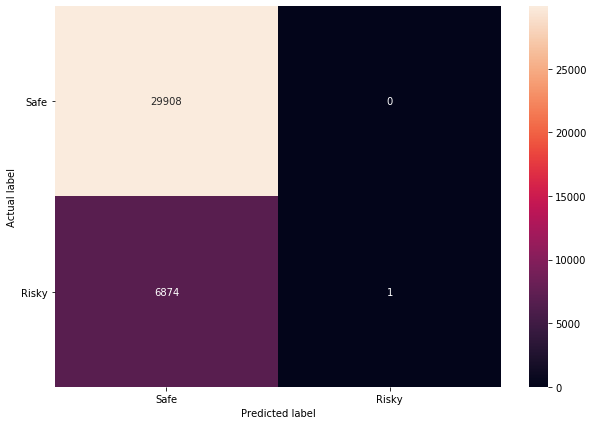

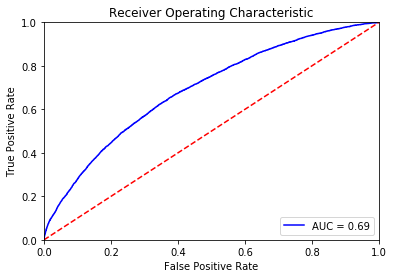

In [48]:
modelRF = Model(df_base, model='RandomForest')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy: 0.8130930049207514
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Cost:  137500000


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


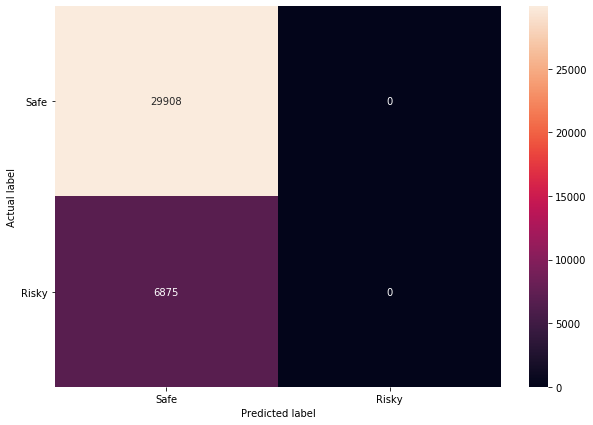

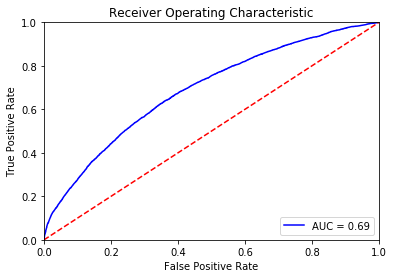

In [49]:
modelReg = Model(df_dummy, model='RandomForest')

**Accuracy** - ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. **The baseline Accuracy score is: 0.816**

Accuracy = TP+TN/TP+FP+FN+TN

**Precision** - ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all loans that labeled as safe, how many were actually safe? High precision relates to the low false positive rate. **The baseline Precision score is: 0.605**

Precision = TP/TP+FP

**Recall (Sensitivity)** - ratio of correctly predicted positive observations to the all observations in actual class - Safe. The question recall answers is: Of all the loans that were truly safe, how many did we label?  above 0.5 is good-ish. **The baseline Recall score is: 0.0496**

Recall = TP/TP+FN

**F1 score** - weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. **The baseline F1 score is: 0.0916**

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

## FEATURE ENGINEERING & SELECTION


In [50]:
df = load_dataset(path, index_col, verbose=False)

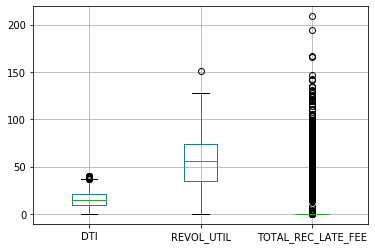

In [51]:
def analyse_outliers(df):
    cont_df = df.select_dtypes(include=['int', 'float'])
    cont_df.boxplot()
analyse_outliers(df)

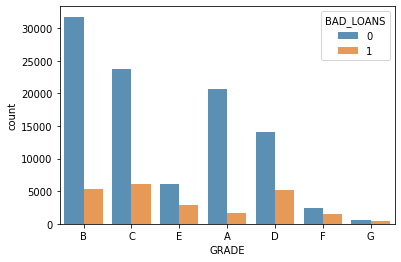

In [52]:
sns.countplot('GRADE', hue='BAD_LOANS', data=df, alpha=0.8)


#### F, and G have the highest risky loan ratio (>50%)


Text(0.5, 1.0, 'Late fee count')

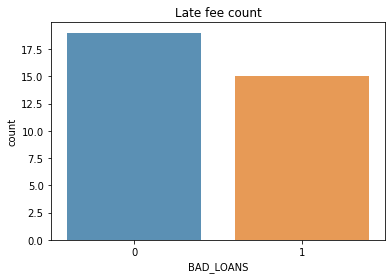

In [53]:
lateFee_df = df.loc[df['TOTAL_REC_LATE_FEE'] > 0]
sns.countplot('BAD_LOANS', data=lateFee_df.loc[df['TOTAL_REC_LATE_FEE'] > 100], alpha=0.8)
plt.title('Late fee count')


In [54]:
lateFee_df.groupby('BAD_LOANS')['TOTAL_REC_LATE_FEE'].sum()

BAD_LOANS
0    40373.279396
1    50643.278100
Name: TOTAL_REC_LATE_FEE, dtype: float64

There are 3421 customers with previous late fees (we don't know how many, only the amount paid). There are more 'risky' borrowers (1859) with late fees than 'safe' ones (1562), although the difference is negligible, and 'safe' borrowers tend to have a higher total of late fees paid. You would expect 'risky' borrowers to have higher total late fees than 'safe' borrowers; the fact that late fee holders are almost evenly distributed can lead to several assumptions:

1. Late fees don't help us distinguish between the two types of borrowers.
2. 'Risky' borrowers have late fees that have not been registered/paid yet - the 'TOTAL_REC_LATE_FEE' feature holds the **'total late fees received to day'**, which can be interpreted as the total amount of late fees received by the borrower, or the total amount of late fees received by the bank from the borrower. In the latter case, we could assume that 'risky' borrowers have received alot of late fees, but simply have not paid them yet, meaning that they are not registered in the 'TOTAL_REC_LATE_FEE' feature.


Further study needed - for now, this feature will be binarized (see **BINARIZATION** section); 1: late fees, 0: no late fees


In [55]:
##if keeping ordinal

#assign grades to EMP_LENGTH_NUM {0: less than 1 year, 1: 1-7 years, 2: 8-10 years, 3: 10+years}
map_emp_length = {'0': '0', '1': '1', '2': '1', '3': '1',
                  '4': '1', '5': '1', '6': '1', '7': '1',
                  '8': '2', '9': '2', '10': '2', '11': '3'}

df['EMP_LENGTH_NUM'] = df['EMP_LENGTH_NUM'].astype(str).map(map_emp_length)

#information from short_emp is available in emp_length_num, so I can drop it
df = df.drop('SHORT_EMP', axis=1)

In [56]:
#simplify DTI & REVOL_UTIL - rounded to nearest 10 - made categorical
df['DTI'] = pd.Series(df['DTI']).round(-1).astype(int)
df['REVOL_UTIL'] = pd.Series(df['REVOL_UTIL']).round(-1).astype(int)
df['TOTAL_REC_LATE_FEE'] = pd.Series(df['TOTAL_REC_LATE_FEE']).round(-1).astype(int)

In [57]:
#binarizing 'TOTAL_REC_LATE_FEE'; 1: have had late fees, 0:not late fees (at least no paid late fees)

df['TOTAL_REC_LATE_FEE'].loc[df['TOTAL_REC_LATE_FEE'] > 0] = 1
df['TOTAL_REC_LATE_FEE'].loc[df['TOTAL_REC_LATE_FEE'] == 0] = 0
df['TOTAL_REC_LATE_FEE'] = df['TOTAL_REC_LATE_FEE'].astype(int)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## RISK RATIOS 


https://stackoverflow.com/questions/43261747/a-better-way-to-calculate-odd-ratio-in-pandas

Calculate risk ratio for different features, create a new column showing the cumulative risk of a loan

In [58]:
def calculate_ratio(df, feature, target_feature):
    risk_count_df = df[feature].loc[df[target_feature] == 1].value_counts()
    safe_count_df = df[feature].loc[df[target_feature] == 0].value_counts()

    risk_dict = {}
    for idx in risk_count_df.index:
        try:
            risk_dict[idx] = np.round((risk_count_df.loc[idx] / (risk_count_df.loc[idx] + safe_count_df.loc[idx])) * 100, 2)
        except:
            risk_dict[idx] = 100
    return risk_dict

def calculate_odd_ratio(df, feature, target_feature):
    risk_count_df = df[feature].loc[df[target_feature] == 1].value_counts()
    safe_count_df = df[feature].loc[df[target_feature] == 0].value_counts()


    whole_df = pd.concat([risk_count_df, safe_count_df], axis=1, sort=False)
    whole_df.columns = ['risky', 'safe']
    risk_dict = {}
    for idx in whole_df.index:
        num = whole_df.loc[idx, 'risky'] / whole_df.loc[idx, 'safe']
        denom = whole_df.loc[idx, 'risky'] / (whole_df['risky'].sum() - whole_df.loc[idx, 'risky'])
        odds = num / denom
        risk_dict[idx] = np.log(odds)
    return risk_dict


In [59]:
def create_odd_ratio_features(df, target):
    original_features = df.loc[:, df.columns != target].columns
    for feature in original_features:
        feature_type = df[feature].dtype
        odds_ratio = calculate_odd_ratio(df=df, feature=feature, target_feature=target)
        df['%s_ODDS'%feature] = df[feature].astype(feature_type).map(odds_ratio)
    df = df.drop(original_features, axis=1)
    return df

def create_precent_ratio_features(df, target):
    original_features = df.loc[:, df.columns != target].columns
    for feature in original_features:
        feature_type = df[feature].dtype
        odds_ratio = calculate_ratio(df=df, feature=feature, target_feature=target)
        df['%s_RISK'%feature] = df[feature].astype(feature_type).map(odds_ratio)
    df = df.drop(original_features, axis=1)
    return df
        
        

In [60]:
df.dtypes

GRADE                    object
SUB_GRADE                object
EMP_LENGTH_NUM           object
HOME_OWNERSHIP           object
DTI                       int64
PURPOSE                  object
TERM                     object
LAST_DELINQ_NONE         object
LAST_MAJOR_DEROG_NONE    object
REVOL_UTIL                int64
TOTAL_REC_LATE_FEE        int64
BAD_LOANS                object
dtype: object

In [61]:
odd_df = create_odd_ratio_features(df=df.select_dtypes(include=['object']), target='BAD_LOANS')
continuous_cols = df.select_dtypes(exclude=['object']).columns
odd_df[continuous_cols] = df[continuous_cols]
odd_df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,BAD_LOANS,GRADE_ODDS,SUB_GRADE_ODDS,EMP_LENGTH_NUM_ODDS,HOME_OWNERSHIP_ODDS,PURPOSE_ODDS,TERM_ODDS,LAST_DELINQ_NONE_ODDS,LAST_MAJOR_DEROG_NONE_ODDS,DTI,REVOL_UTIL,TOTAL_REC_LATE_FEE
0,0,-0.581877,1.276114,-0.500685,-1.255261,0.057650,-2.389426,-1.806759,-3.406367,30,80,0
1,1,-0.336741,1.587801,-1.653064,-1.255261,-1.724416,-2.389426,-1.105583,-3.406367,20,40,0
2,0,1.201392,2.922320,-0.500685,0.974267,0.057650,-2.389426,-1.105583,-3.406367,20,70,0
3,0,-0.581877,1.144229,0.403163,-1.321400,1.915366,-2.389426,-1.105583,-3.406367,20,70,0
4,1,-0.581877,1.342294,-0.500685,-1.255261,3.327730,-2.389426,-1.105583,-3.406367,10,80,0


In [62]:
#create cumulative odd ratio risk feature

odd_df['TOTAL_ODDS'] = odd_df.filter(regex=('_ODDS')).sum(axis=1)

In [64]:
#some (3) features have only one count, so return NaN ()
odd_df = odd_df.dropna()

In [65]:
#select Best - here we converted all features to binary, later we will try to keep some ordinal categories
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif

def select_KBest(df, col_names, train, test, target='Response', score_func=mutual_info_classif, k = 12):
    '''
    Prints ranked pvalues and scores of all features and returns a dataframe with only those selected features
    and the target feature. n.b: maintains the index of all rows throughout so the target feature is in the right place
    when added at the end.

    For more info on sklearn.selectKBest and parameters, visit - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest
    :param score_func: function used to calculate score and p-value, default is 'chi2'
    can be: 'chi2', 'f_classif', 'f_regression', 'mutual_info_regression' - more can be added but need to be imported
    :param k: number of features to select
    :param X: features
    :param y: target
    :return: dataframe with selected features and target
    '''
    feat_selector = SelectKBest(score_func=score_func, k=k) 
    selector = feat_selector.fit(train, test)

    feat_scores = pd.DataFrame()
    feat_scores["Score"] = np.round(selector.scores_,3)
    feat_scores["Pvalue"] = selector.pvalues_
    feat_scores["Support"] = selector.get_support()
    feat_scores["Attribute"] = col_names

    feat_scores = feat_scores.sort_values('Score', ascending=False, axis=0)
    # print(sorted_df)
    feat_scores = feat_scores.iloc[:k, :]  # get selected number of rows from ranking
    sorted_columns = feat_scores['Attribute'].values  # get column names

    print("Ranked input features:\n", feat_scores)
    
    # get columns with score above threshold
    feat_scores = feat_scores.loc[feat_scores['Score'] > 600]
    sorted_columns = feat_scores['Attribute'].values  # get column names

    new_df = df[sorted_columns] #create new DF with selected rows - created in def __init__()
    new_df[target] = df[target].values.astype(int) # add 'Response' column to new dataframe
    print("New DataFrame Columns:\n", new_df.columns)
    print('Length of new_df: \n', len(new_df))
    print(new_df.dtypes)

    
    return new_df   

In [66]:
x_train, x_test, y_train, y_test = split_and_scale(odd_df)

new_df_risk = select_KBest(odd_df, odd_df.drop('BAD_LOANS', axis=1).columns, 
                       train=x_train, test=y_train, target='BAD_LOANS', score_func=f_classif, 
                       k = len(odd_df.drop('BAD_LOANS', axis=1).columns))

Ranked input features:
        Score         Pvalue  Support                   Attribute
1   2215.210   0.000000e+00     True              SUB_GRADE_ODDS
10  1958.802   0.000000e+00     True          TOTAL_REC_LATE_FEE
0   1926.158   0.000000e+00     True                  GRADE_ODDS
5   1924.471   0.000000e+00     True                   TERM_ODDS
11  1227.807  4.308462e-267     True                  TOTAL_ODDS
9   1083.152  4.521994e-236     True                  REVOL_UTIL
8    850.280  5.145930e-186     True                         DTI
2     70.155   5.564468e-17     True         EMP_LENGTH_NUM_ODDS
6      7.268   7.021159e-03     True       LAST_DELINQ_NONE_ODDS
3      6.239   1.249947e-02     True         HOME_OWNERSHIP_ODDS
4      4.992   2.546896e-02     True                PURPOSE_ODDS
7      0.108   7.420340e-01     True  LAST_MAJOR_DEROG_NONE_ODDS
New DataFrame Columns:
 Index(['SUB_GRADE_ODDS', 'TOTAL_REC_LATE_FEE', 'GRADE_ODDS', 'TERM_ODDS',
       'TOTAL_ODDS', 'REVOL_UTIL'

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
new_df_risk.head()

,SUB_GRADE_ODDS,TOTAL_REC_LATE_FEE,GRADE_ODDS,TERM_ODDS,TOTAL_ODDS,REVOL_UTIL,DTI,BAD_LOANS
0,1.276114,0,-0.581877,-2.389426,-8.606611,80,30,0
1,1.587801,0,-0.336741,-2.389426,-10.283057,40,20,1
2,2.922320,0,1.201392,-2.389426,-2.246432,70,20,0
3,1.144229,0,-0.581877,-2.389426,-5.341895,70,20,0
4,1.342294,0,-0.581877,-2.389426,-4.569175,80,10,1


## Compare Over Sampling (SMOTE) to Under Sampling

#### Under sampling

In [68]:
#build undersampled dataset
risky_df = new_df_risk.loc[new_df_risk['BAD_LOANS'] == 1]
safe_df = new_df_risk.loc[new_df_risk['BAD_LOANS'] == 0].sample(int(len(risky_df)*1.2)).reset_index().drop('index', axis=1)
undersamp_df = pd.concat([risky_df, safe_df])
undersamp_df = undersamp_df.sample(frac=1).reset_index(drop=True)
undersamp_df['BAD_LOANS'].value_counts()

0    27780
1    23150
Name: BAD_LOANS, dtype: int64

In [69]:
training_features, test_features, training_target, test_target, = split_and_scale(new_df_risk)

X = undersamp_df.drop('BAD_LOANS', axis=1)
y = undersamp_df['BAD_LOANS']
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state=0)


Validation Results
0.6359054911970679
0.4340407226842558

Test Results
0.8167088056982845
0.08145454545454546


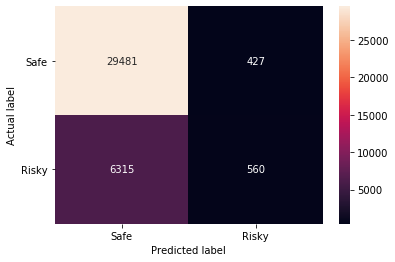

Accuracy: 0.8167088056982845
Precision: 0.5673758865248227
Recall: 0.08145454545454546
F1 Score: 0.14245738997710508
Cost:  130570000


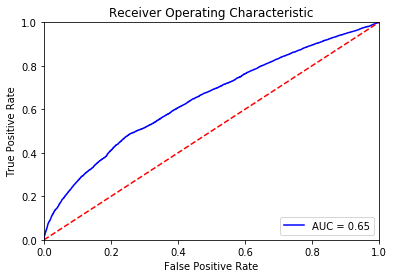

In [70]:
clf_rf = LogisticRegression()
clf_rf.fit(x_train, y_train)

print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(metrics.recall_score(y_val, clf_rf.predict(x_val)))
print('\nTest Results')
print(clf_rf.score(test_features, test_target))
print(metrics.recall_score(test_target, clf_rf.predict(test_features)))



#confusion_matrix
cnf_matrix = metrics.confusion_matrix(test_target,  clf_rf.predict(test_features))
df_cm = pd.DataFrame(cnf_matrix, columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
hm = sns.heatmap(df_cm, annot=True, fmt='g')
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

unbal_pred = clf_rf.predict(test_features)
print('Accuracy:',metrics.accuracy_score(test_target, unbal_pred))
print('Precision:',metrics.precision_score(test_target, unbal_pred))
print('Recall:',metrics.recall_score(test_target, unbal_pred))
print('F1 Score:',metrics.f1_score(test_target, unbal_pred))
print('Cost: ', calculate_cost(cnf_matrix))

y_prob = clf_rf.predict_proba(test_features)[:,1]



#auroc
fpr, tpr, threshold = metrics.roc_curve(test_target, y_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Unchanged dataset (unbalanced)

Accuracy: 0.8174156539705842
Precision: 0.5987577639751552
Recall: 0.07010909090909091
F1 Score: 0.12552083333333333
Cost:  131090000


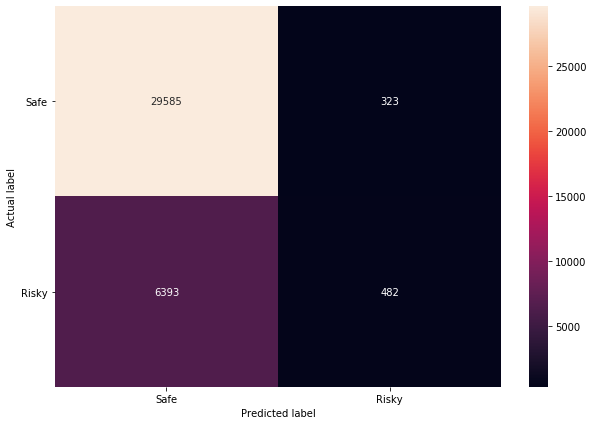

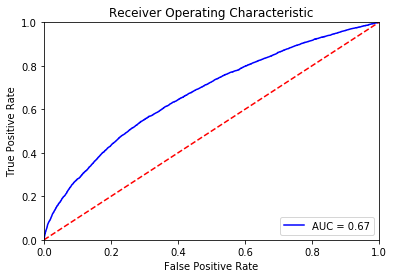

In [71]:
#model with no over or under sampling
model = Model(new_df_risk, test_size=0.3, threshold=0.5, model='LogisticRegression', target='BAD_LOANS')


#### Over sampling

In [72]:
##OVERSAMPLING
training_features, test_features, training_target, test_target, = split_and_scale(new_df_risk)


x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = 0.3,
                                                  random_state=12)

sm = SMOTE(random_state=0, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Validation Results
0.6856066490601211
0.5372362432767894

Test Results
0.6815648533289835
0.5377454545454545


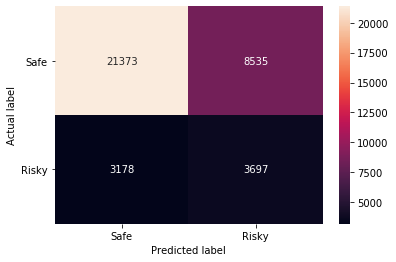

Accuracy: 0.6815648533289835
Precision: 0.30224002616088946
Recall: 0.5377454545454545
F1 Score: 0.3869785942324802
Cost:  148910000


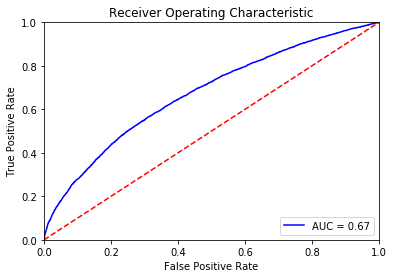

In [73]:
#ONLY FOR SMOTE
clf_rf = LogisticRegression()
clf_rf.fit(x_train_res, y_train_res)

print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(metrics.recall_score(y_val, clf_rf.predict(x_val)))
print('\nTest Results')
print(clf_rf.score(test_features, test_target))
print(metrics.recall_score(test_target, clf_rf.predict(test_features)))



#confusion_matrix
cnf_matrix = metrics.confusion_matrix(test_target,  clf_rf.predict(test_features))
df_cm = pd.DataFrame(cnf_matrix, columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
hm = sns.heatmap(df_cm, annot=True, fmt='g')
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

unbal_pred = clf_rf.predict(test_features)
print('Accuracy:',metrics.accuracy_score(test_target, unbal_pred))
print('Precision:',metrics.precision_score(test_target, unbal_pred))
print('Recall:',metrics.recall_score(test_target, unbal_pred))
print('F1 Score:',metrics.f1_score(test_target, unbal_pred))
print('Cost: ', calculate_cost(cnf_matrix))

y_prob = clf_rf.predict_proba(test_features)[:,1]



#auroc
fpr, tpr, threshold = metrics.roc_curve(test_target, y_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Under Sampling delivers best results**

## BUILD MODELS

In [79]:
def cost_scorer(y_test, y_pred):
    y_test = np.array(y_test)
##!!! NOTE - do select k best separately for categorical & continous
    diff_df = pd.DataFrame({'test': y_test, 'pred': y_pred})
    diff_df['diff'] = diff_df['test'] - diff_df['pred']
    diff_df['diff'] = diff_df['diff'].replace({255 : -1})
    counts = diff_df['diff'].value_counts()
    false_neg = counts.loc[-1]
    false_pos = counts.loc[1]
    cost = (false_neg * 10000) + (false_pos * 20000)
    #need to return as negative because make scorer flips sign when 'greater_is_beter'=false
    return cost

def AUROC(y_test, y_prob, plot=True):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    print('AUC: %s'%np.round(roc_auc, 3))

    if plot == True:
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show(block=False)

    return roc_auc

In [80]:
#make custom cost scorer for grid search
grid_cost_scorer = metrics.make_scorer(cost_scorer, greater_is_better=False, needs_proba=True)


In [77]:
#build undersampled dataset
risky_df = new_df_risk.loc[new_df_risk['BAD_LOANS'] == 1]
safe_df = new_df_risk.loc[new_df_risk['BAD_LOANS'] == 0].sample(int(len(risky_df)*1.2)).reset_index().drop('index', axis=1)
undersamp_df = pd.concat([risky_df, safe_df])
undersamp_df = undersamp_df.sample(frac=1).reset_index(drop=True)
undersamp_df['BAD_LOANS'].value_counts()

0    27780
1    23150
Name: BAD_LOANS, dtype: int64

In [78]:
#split dataset - first split to test (will use test_features to predict, test_target to evaluate)
training_features, test_features, training_target, test_target, = split_and_scale(new_df_risk)


#split undersampled data (will use x_train, y_train to train model (undersampled), then test_features to predict, test_target to evaluate)
X = undersamp_df.drop('BAD_LOANS', axis=1)
y = undersamp_df['BAD_LOANS']
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state=12)

In [82]:
#model & parameter dictionaries for Grid Search
seed = 3
models = {
    'RF': RandomForestClassifier(),
    'neighbours': KNeighborsClassifier(),
    'logistic': LogisticRegression(),
    'mlp': MLPClassifier(),
    'svc': SVC()
}
params = {
    'RF': {
        'max_depth': [4, 8],
        'n_estimators': [100, 200],
        'max_features': ['auto', 'log2'],
        'bootstrap': [True],
        'criterion': ['gini'],
        'oob_score': [False]
    },
    'neighbours': {
        'n_neighbors': np.arange(3, 15),
        'weights': ['uniform', 'distance'],
        'algorithm': ['kd_tree', 'brute']
    },
    'mlp': {
        'solver': ['adam', 'sgd'],
        'max_iter': [500,1000,1500],
        'alpha': 10.0 ** -np.arange(1, 10, 3),
        'hidden_layer_sizes': np.arange(10, 16,2)
    },
    'logistic': {
        'C':np.logspace(-3,3,4), 
        'penalty':['l1','l2'],
        'random_state' : [seed],
      },
    'svc': {
         'kernel': ['rbf'], 
         'gamma': [1e-3, 1e-4],
         'C': [500, 1000]
    }
}

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

**NOTE**: No need to run this (slow), the best estimators are already saved below

In [ ]:
threshold = 0.5
dict_best = {}
for name in models.keys():
    print(name)
    est = models[name]
    est_params = params[name]
    model = GridSearchCV(estimator=est, param_grid=est_params, cv=5,
                        scoring=grid_cost_scorer, verbose=3) #can also set scoring='precision_micro'
    model.fit(x_train, y_train)
    print("best estimator is: {}".format(model.best_estimator_))
    print("best score are: {}".format(model.best_score_))
    print("best parameters are: {}".format(model.best_params_))
    best_estimator = model.best_estimator_
    dict_best[name] = best_estimator
    
    y_prob = model.predict_proba(test_features)[:, 1]

    predictions_df = pd.DataFrame({'y_prob': y_prob, 'y_test': test_target})
    predictions_df.to_csv('predict_proba_%s_%s_recall.csv'%(name, threshold))

    unbal_pred = [0 if v < threshold else 1 for v in y_prob]

    cnf_matrix = metrics.confusion_matrix(test_target, unbal_pred)
    df_cm = pd.DataFrame(cnf_matrix)  # , columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
    hm = sns.heatmap(df_cm, annot=True, fmt='g')
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show(block=False)

    print('Accuracy:', metrics.accuracy_score(test_target, unbal_pred))
    print('Precision:', metrics.precision_score(test_target, unbal_pred))
    print('Recall:', metrics.recall_score(test_target, unbal_pred))
    print('F1 Score:', metrics.f1_score(test_target, unbal_pred))

    #calculate cost
    y_test = np.array(y_test)
    diff_df = pd.DataFrame({'test': y_test, 'pred': unbal_pred})
    diff_df['diff'] = diff_df['test'] - diff_df['pred']
    diff_df['diff'] = diff_df['diff'].replace({255 : -1})
    counts = diff_df['diff'].value_counts()
    try:
        false_neg = counts.loc[-1]
    except:
        print('no FN')
        false_neg = 0
    try:
        false_pos = counts.loc[1]
    except:
        print('no FP')
        false_pos = 0
        
    cost = (false_neg * 10000) + (false_pos * 20000)
    
    print('cost: ', cost)

    filename = 'models/%s_precision_micro.sav'%name
    pickle.dump(best_estimator, open(filename, 'wb'))
    
    # Save to file in the current working directory
    pkl_filename = 'models/%s_precision_micro.pkl'%name
    with open(pkl_filename, 'wb') as file:
        pickle.dump(best_estimator, file)
    
    auc = AUROC(test_target, y_prob, plot=True)
    


dict_best = {} will return the best estimator for each model in the models dict


In [ ]:
dict_best


## Train model on full dataset

Now that we have the best estimators, we can train the models on the whole undersampled dataset. These models will be used to make predictions on new data in the application.

Note that we have two sets of optimal models; those optmizied of the custom cost_scorer and those optimized on 'precision_recall'

#### precision_micro

In [83]:
#create undersampled dataset
risky_df = new_df_risk.loc[new_df_risk['BAD_LOANS'] == 1]
safe_df = new_df_risk.loc[new_df_risk['BAD_LOANS'] == 0].sample(int(len(risky_df)*1.2)).reset_index().drop('index', axis=1)
undersamp_df = pd.concat([risky_df, safe_df])
undersamp_df = undersamp_df.sample(frac=1).reset_index(drop=True)

#this sample is . used to train scv - otherwise it takes too long
sampl_data = undersamp_df.sample(10000)

In [ ]:
#create training % testing data - full dataset
X = undersamp_df.drop('BAD_LOANS', axis=1)
y = undersamp_df['BAD_LOANS']

In [ ]:
#SVC
Xsamp = sampl_data.drop('BAD_LOANS', axis=1)
ysamp = sampl_data['BAD_LOANS']

model = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model.fit(Xsamp,ysamp)

##ONLY used if we want to make predictions - not necessary here since model is trained on whole dataset
# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('svc_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'models/svc_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#MLP
model = MLPClassifier(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=12, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('mlp_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'models/mlp_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [64]:
#Logistic Regression
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=3, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('logistic_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'models/logistic_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [65]:
#KNeighbours
model = KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=14, p=2,
           weights='uniform')
model.fit(X,y)


# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('neighbours_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'models/neighbours_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [66]:
#RF
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('RF_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'models/RF_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

#### cost_scorer

In [31]:
#MLP
model = MLPClassifier(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=12, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# y_prob = model.predict_proba(test_features)[:,1]

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('mlp_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'models/mlp_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [35]:
#LogisticRegression
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=3, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)
# y_prob = model.predict_proba(test_features)[:,1]


# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('logistic_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'models/logistic_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [36]:
#KNeighbours
model = KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')
model.fit(X,y)

# y_pred = model.predict(test_features)
# y_prob = model.predict_proba(test_features)[:,1]


# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('neighbours_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'models/neighbours_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [37]:
#RF
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# y_prob = model.predict_proba(test_features)[:,1]


# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('RF_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'models/RF_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [40]:
#SVC
Xsamp = sampl_data.drop('BAD_LOANS', axis=1)
ysamp = sampl_data['BAD_LOANS']

model = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model.fit(Xsamp,ysamp)


# y_pred = model.predict(test_features)
# y_prob = model.predict_proba(test_features)[:,1]


# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('svc_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'models/svc_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)